# 梯度不平稳性与Glorot条件

从链式求导的角度来看，梯度消失和梯度爆炸的问题主要发生在使用反向传播算法进行训练的过程中。反向传播算法涉及到对损失函数相对于每个权重的梯度计算，而这些梯度是通过链式法则（Chain Rule）得到的。

#### 链式法则

在神经网络中，输出相对于输入的梯度可以分解为一系列中间变量相对于它们的前驱的梯度的乘积。具体来说，如果有一个由多层组成的神经网络，第$ l $层的输出依赖于第$ l-1 $层的输出，那么我们可以写成：

$$ \frac{\partial L}{\partial w_l} = \frac{\partial L}{\partial z_l} \cdot \frac{\partial z_l}{\partial w_l} $$

其中：
- $ L $ 是损失函数。
- $ w_l $ 是第$ l $层的权重。
- $ z_l $ 是第$ l $层的线性组合输出（通常是$ w_l \cdot a_{l-1} + b_l $，其中$ a_{l-1} $是第$ l-1 $层的激活）。

对于更深层次的情况，我们有：

$$ \frac{\partial L}{\partial w_{l-1}} = \frac{\partial L}{\partial z_l} \cdot \frac{\partial z_l}{\partial a_{l-1}} \cdot \frac{\partial a_{l-1}}{\partial z_{l-1}} \cdot \frac{\partial z_{l-1}}{\partial w_{l-1}} $$

以此类推，直到输入层。这里，$\frac{\partial z_l}{\partial a_{l-1}}$ 和 $\frac{\partial a_{l-1}}{\partial z_{l-1}}$ 分别对应了第$ l $层的权重矩阵和激活函数的导数。

#### 成因分析

**梯度消失：**

当网络很深时，上述梯度的乘积可能包含许多项，每项都是一个激活函数的导数。如果使用的激活函数（如Sigmoid或Tanh）在输入远离0的情况下导数接近0，则乘积中的很多因子都会很小。随着深度增加，这种效应会累积，最终导致梯度变得非常小，这就是梯度消失。

**梯度爆炸：**

与此相反，如果乘积中的某些因子变得非常大（例如，当激活函数的导数在某些区域很大时），或者权重本身非常大，那么整个乘积也可能变得非常大，导致梯度爆炸。

总结一下，不同层参数的梯度在计算过程中都有很大的差异，并且这种差异是一种累乘效应，我们也可以简单理解为是一种伴随着层数增加指数级变化的差异。而这种累乘效应会导致线性层参数的一部分梯度过大而另一部分过小，从而影响模型平稳训练。而从具体原因来说，每一层参数的梯度主要和两个因素相关，其一是线性层输入数据，其二则是激活函数导函数计算结果。

#### 影响因素

梯度消失和梯度爆炸的影响因素包括但不限于以下几点：

- **激活函数的选择**：不同的激活函数有不同的导数特性。例如，Sigmoid和Tanh函数在输入远离原点时导数趋近于0，而ReLU函数在正半轴上的导数恒为1，这有助于缓解梯度消失。
- **网络的深度**：更深的网络意味着更多的梯度乘积项，更容易遇到梯度消失或爆炸的问题。
- **权重初始化**：不恰当的权重初始化可能导致梯度问题，比如太大的权重可能引发梯度爆炸，而太小的权重可能加剧梯度消失。
- **正则化技术**：如L1或L2正则化可以帮助控制权重大小，从而间接地影响梯度的大小。
- **梯度裁剪**：可以手动设定一个阈值，将梯度裁剪到一个合理范围内，防止梯度爆炸。

通过调整这些因素，可以有效地缓解梯度消失和梯度爆炸带来的问题。

## 二、Sigmoid和tanh激活函数的梯度更新问题

### 1.Sigmoid激活函数的梯度消失问题

- 理论说明

&emsp;&emsp;对于sigmoid激活函数来说，简单的叠加是极容易出现梯度消失的问题。sigmoid函数及导函数图像如下所示：

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# 绘制Sigmoid函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
X.requires_grad=True
sigmoid_y = torch.sigmoid(X)

In [3]:
# 反向传播
sigmoid_y.sum().backward()

Text(0.5, 1.0, 'Sigmoid Derivative function')

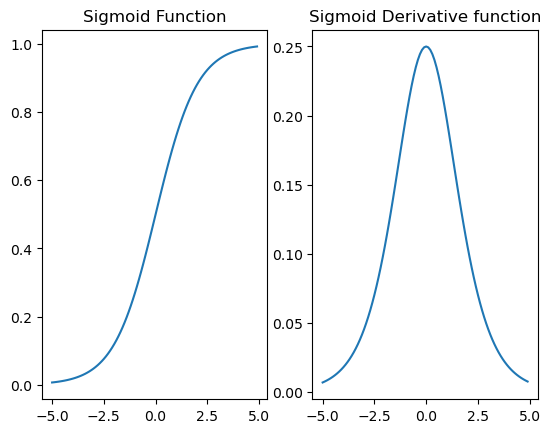

In [6]:
# Sigmoid函数图像
plt.subplot(121)
plt.plot(X.detach(), sigmoid_y.detach())
plt.title("Sigmoid Function")
# Sigmoid导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title("Sigmoid Derivative function")

我们发现，Sigmoid导函数最大值为0.25（在0点处取到），当x较大或者较小时，导函数取值趋于0。梯度消失或者梯度爆炸，始终是个概率问题。我们不能说导函数取值取值小就一定会发生梯度消失问题，只是导函数最大值越小，越有可能发生梯度消失。   

- Sigmoid函数饱和区间

&emsp;&emsp;一般来说我们会将靠近sigmoid函数的左右两端的区间称为函数的饱和区间（如下图圈出部分）（也就是自变量绝对值较大的区间），不难发现，当自变量落入饱和区间时，因变量会趋于0或者1，而无论自变量是极小（负数绝对值极大）还是极大，都会使得导函数取值趋于0，从而更容易导致模型梯度消失。

<img src="https://i.loli.net/2021/02/24/nXN6Gq8521f7tDU.jpg" alt="64" style="zoom:50%;" />

In [1]:
import torch
import torch.nn as nn
import numpy as np

# 设置随机种子
np.random.seed(0)
torch.manual_seed(0)

# 如果有GPU可用，使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class SimpleNetwork(nn.Module):
    def __init__(self, layers):
        super(SimpleNetwork, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 定义一个深层的网络结构
input_size = 1
hidden_sizes = [64] * 10  # 十个隐藏层，每层64个节点
output_size = 1
layers = [input_size] + hidden_sizes + [output_size]
model = SimpleNetwork(layers).to(device)

In [3]:
# 创建一个随机输入
input_data = torch.randn(1, input_size).to(device)
output = model(input_data)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 1])


In [4]:
# 假设一个损失函数
loss_fn = nn.MSELoss()
target = torch.tensor([[0.5]]).to(device)  # 假设目标值为0.5
loss = loss_fn(output, target)

print("Initial Loss:", loss.item())

Initial Loss: 0.002793394261971116


In [5]:
# 清零梯度
model.zero_grad()

# 反向传播
loss.backward()

# 获取第一层和最后一层的权重梯度
first_layer_grad = list(model.parameters())[0].grad
last_layer_grad = list(model.parameters())[-2].grad

print("First Layer Weight Grad:", first_layer_grad.abs().mean().item())
print("Last Layer Weight Grad:", last_layer_grad.abs().mean().item())

First Layer Weight Grad: 1.4004288180491375e-12
Last Layer Weight Grad: 0.012725936248898506


由于Sigmoid激活函数叠加会造成严重梯度消失问题，因此复杂模型，如Sigmoid3和Sigmoid4的前几层在迭代过程中逐渐丧失变化的可能性，也就是学习能力，从而导致经过了很多轮的迭代，但最终结果只能和Sigmoid2和Sigmoid3持平的情况。

> 需要注意的是，对于复杂模型来说，如果部分层失去学习能力（参数迭代的可能性），其实模型判别效力就和简单模型无异。从此也能看出对复杂模型进行有效训练的重要性。

### 2.tanh函数的梯度计算问题

&emsp;&emsp;如果说Sigmoid激活函数叠加更容易造成梯度消失，那tanh激活函数叠加是不是也是如此呢？首先我们来观察tanh激活函数导函数性质。

In [72]:
# 绘制tanh函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
X.requires_grad=True
tanh_y = torch.tanh(X)

In [73]:
# 反向传播
tanh_y.sum().backward()

<AxesSubplot:>

Text(0.5, 1.0, 'tanh Function')

<AxesSubplot:>

Text(0.5, 1.0, 'tanh Derivative function')

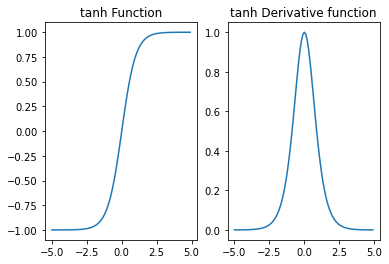

In [74]:
# tanh函数图像
plt.subplot(121)
plt.plot(X.detach(), tanh_y.detach())
plt.title("tanh Function")
# tanh导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title("tanh Derivative function")

对于tanh函数来说，导函数的取值分布在0-1之间的，看似导函数取值累乘之后也是趋于0的，但实际上，tanh激活函数的叠加即可能造成梯度消失、同时也可能造成梯度爆炸，原因是在实际建模过程中，影响前几层梯度的其他变量大多数情况都大于1，因此对于一个导函数极大值可以取到1的激活函数来说，还是有可能出现梯度爆炸的情况的。

> 梯度爆炸和梯度消失中，所谓的前几层参数梯度过大或者过小也都是相对的概念，并没有明确定义梯度大过多少就是梯度爆炸、梯度小过多少就是梯度消失。另外，梯度爆炸和梯度消失的直接表现可归结为前后参数层梯度不一致，而二者的根本问题都是影响迭代收敛过程。

> 作为Sigmoid激活函数的“升级版”，tanh激活函数除了能够一定程度规避梯度消失问题外，还能够生成Zero-Centered Data，而确保输入层接收到Zero-Centered Data，则是解决梯度消失和梯度爆炸问题的关键。

和Sigmoid激活函数一样，我们可以通过绘制小提琴图观察多轮迭代后，tanh激活函数叠加的神经网络是否会出现梯度消失或者梯度爆炸的情况。类似的，首先我们利用此前定义的模型，实例化一个拥有四个隐藏层的以tanh为激活函数的模型，然后观察模型在迭代过程中梯度变化情况。

从根本上来说，tanh激活函数的迭代不平稳就是因为部分层的部分梯度存在极端值，当然，这种极端值也导致部分层无法有效学习、最终影响模型效果。

## ReLU 函数

尽管ReLU在缓解梯度消失方面表现良好，但它并不能完全解决梯度爆炸问题。梯度爆炸通常发生在‌深层网络中，当权重初始化过大时，梯度在反向传播过程中会累积并变得非常大，导致模型无法收敛。为了应对梯度爆炸，除了使用ReLU激活函数外，还可以采取其他措施，如‌批量归一化（Batch Normalization）、‌梯度剪裁（Gradient Clipping）以及合理设置学习率等策略。这些方法共同作用，可以在一定程度上减轻梯度爆炸的影响，确保网络训练的稳定性和有效性。

## 三、Zero-Centered Data与Glorot条件

&emsp;&emsp;通过对Sigmoid和tanh激活函数叠加后的模型梯度变化情况分析，我们不难发现，梯度不平稳是影响模型建模效果的非常核心的因素。而这个看似简单问题的解决方案，却花费了研究人员数十年的时间才逐渐完善，我们现在所接触到的优化方法，也基本上是在15年前后提出的，而这些被验证的切实可行的优化方法，也是推动这一轮深度学习浪潮的技术因素。

> 当然，这些优化方法主要是针对深层次神经网络的。

&emsp;&emsp;整体来看，针对梯度不平稳的解决方案（优化方法）总共分为五类，分别是参数初始化方法、输入数据的归一化方法、衍生激活函数使用方法、学习率调度方法以及梯度下降优化方法。接下来，先介绍所有上述优化算法的一个基本理论，由Xavier Glorot在2010提出的Glorot条件。

> 值得注意的是，虽然不同优化算法有不同的出发点和不同的论证方式，但基本都可以从Glorot条件出发进行思考。

### 1.Zero-centered Data


&emsp;&emsp;在介绍Glorot条件之前，我们先从一个更加朴素的角度出发，讨论关于Zero-Centered Data相关作用，从而帮助我们理解后续Glorot条件。

&emsp;&emsp;首先，我们还是假设当前模型是一个三层神经网络，其中两个隐藏层的激活函数为$F(x)$，对应的导函数为$f(x)$，设X为输入训练的数据特征，y为标签，$\hat y$为模型向前传播输出结果，$w_1$为第一层参数、$w_2$为第二层参数、$w_3$为第三层参数，loss为损失函数，则有如下计算公式：

每一次正向传播计算结果：

$$\hat y = F(F(X * w_1) * w_2) * w_3$$

假设$Z_i$为第i层接收到的数据，$P_i$为第i层输出的数据，则有：

$$Z_1 = X*w_1$$

$$P_1 = F(Z_1) = F(X*w_1)$$

$$Z_2 = P_1 * w_2 = F(X*w_1)*w_2$$

$$P_2 = F(Z_2) = F(F(X*w_1)*w_2)$$

$$Z_3 = \hat y = F(F(X * w_1) * w_2) * w_3$$

依次类推。而在反向传播过程，各参数层的梯度如下

$$
grad_1 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
w_2 \cdot f(X * w_1) \cdot X 
$$

$$
grad_2 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) 
$$

$$
grad_3 = \frac{\partial loss}{\partial \hat y} 
\cdot 
F(F(X * w_1) * w_2)
$$

&emsp;&emsp;在梯度消失和梯度爆炸的案例中，我们不难发现，为了确保多层神经网络的有效性，各层梯度的差距不应太大，此时一个最为基本的想法就是，就是能否让所有的输入数据（也就是X）以及所有层的参数都设置为Zero-Centered Data，也就是零点对称数据，不难发现，由于X和$w_i$都是零点对称的，因此每一个线性层中的导函数也取值也能够维持在0-1之间，进而每一层的梯度基本能维持在比较平稳的状态。

> 另外，除了能够避免梯度不平稳问题以外，创建Zero-Centered的参数和数据集，还能够更好的在正向传播中将信息传播到各层，以及确保各层学习的平稳性。

&emsp;&emsp;关于如何将带入模型训练的数据转化为Zero-Centered Data，一般来说我们会使用一系列标准化方法对其进行转化，具体方法我们会在Lesson 14进行详细介绍，由于我们此前创建的数据生成器生成的就是Zero-Centered Data，因此暂时这些数据不会影响接下来的优化方法使用。而如何将参数转化为Zero-Centered Data，就是核心需要考虑的问题了。

> 对于输入的数据来说，我们可以尽量保证其Zero-Centered的特性，但模型参数是随着模型迭代不断变化的，我们无法把控模型每一轮迭代后的情况，因此只能从模型参数初始值入手，尽量保证其Zero-Centered属性。

&emsp;&emsp;当然，既然是创建Zero-Centered参数，那能否创建初始值全是0的参数呢？我们可以简单尝试一下:

In [33]:
class Sigmoid_class1_test(nn.Module):                                   
    def __init__(self, in_features=2, n_hidden=2, out_features=1, bias=False):       
        super(Sigmoid_class1_test, self).__init__()
        self.linear1 = nn.Linear(in_features, n_hidden, bias=bias)
        self.linear2 = nn.Linear(n_hidden, out_features, bias=bias)
        
    def forward(self, x):                                   
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)                   
        out = self.linear2(p1)
        return out

# 创建随机数种子
torch.manual_seed(420) 

# 创建模型
sigmoid_test = Sigmoid_class1_test()

In [38]:
# 观察各层参数
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[ 0.4318, -0.4256],
         [ 0.6730, -0.5617]], requires_grad=True),
 Parameter containing:
 tensor([[-0.2157, -0.4873]], requires_grad=True)]

In [41]:
# 将各层参数修改为0
list(sigmoid_test.parameters())[0].data = torch.tensor([[0., 0], [0, 0]])
list(sigmoid_test.parameters())[1].data = torch.tensor([[0., 0]])

In [42]:
# 查看修改结果
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[0., 0.],
         [0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0.]], requires_grad=True)]

> 或者也可以通过torch.full_like(list(sigmoid_test.parameters())[0], 0)进行修改，然后再令其可导并替换原始参数值。

In [43]:
# 遍历五次查看结果
fit(net = sigmoid_test, 
    criterion = nn.MSELoss(), 
    optimizer = optim.SGD(sigmoid_test.parameters(), lr = 0.03), 
    batchdata = train_loader, 
    epochs=5, 
    cla=False)

In [45]:
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[ 0.5914, -0.0281],
         [ 0.5914, -0.0281]], requires_grad=True),
 Parameter containing:
 tensor([[1.0375, 1.0375]], requires_grad=True)]

我们发现，参数的每一列（最后一个参数的一行）都是同步变化的，大家可以思考一下出现这种情况的原因是什么~？

&emsp;&emsp;很明显，我们不能将参数的初始值全部设为0，我们只能考虑借助统计工具生成均值是0的随机数，也就是0均值的均匀分布或者是0均值的高斯分布，但这里需要考虑的另一个问题就是，该随机数的方差应该如何确定？

### 2.Glorot条件和Xavier方法

&emsp;&emsp;初始化参数的方差如何确定这一问题在一个严谨论述如何保证模型有效性的论文中，从另一个角度出发，得到了回答。根据Xavier Glorot在2010年发表的[《Understanding the difficulty of training deep feedforward neural networks》](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)论文中的观点，为保证模型本身的有效性和稳定性，我们希望正向传播时，每个线性层输入数据的方差等于输出数据的方差，同时我们也希望反向传播时，数据流经某层之前和流经某层之后该层的梯度也具有相同的方差，虽然二者很难同时满足（除非相邻两层神经元个数相同），但Glorot和Bengio（论文第二作者）表示，如果我们适当修改计算过程、是可以找到一种折中方案去设计初始参数取值，从而同时保证二者条件尽可能得到满足，这种设计参数初始值的方法也被称为Xavier方法，而这种方法也经过一段时间的实践验证被证明是很好的一种初始化模型参数的方法，尤其是对于使用tanh激活函数的神经网络来说，效果更为显著。

&emsp;&emsp;而这种正向传播时数据方差保持一致、反向传播时参数梯度方差保持一致的条件，也被称为Glorot条件，满足该条件的模型能够进行有效平稳的训练，而为了满足该条件而创建的（当然也是由上述论文提出的）模型初始化参数值设计方法，也被称为Xavier方法。而在Xavier方法中，最核心解决的问题，也就是为了创建Zero-Centered的初始化参数时参数的方差。和我们从朴素的角度思考的方向是一致的。

&emsp;&emsp;由于Glorot条件和Xavier方法是在2010年提出的，彼时ReLU激活函数还未兴起，因此Xavier方法主要是围绕tanh激活函数可能存在的梯度爆炸或梯度消失进行的优化，Sigmoid激活函数效果次之。不过尽管如此，Glorot条件却是一个通用条件，后续围绕ReLU激活函数、用于解决神经元活性失效的优化方法（如HE初始化方法），也是遵照Glorot条件进行的方法设计。

### 3.模型初始化参数取值影响

&emsp;&emsp;Xavier初始化方法的推导和使用我们将在下一节详细介绍，此处我们先通过另外一个实例，去展示为何初始参数取值不同，会够得到不同的建模结果。模型初始化时得到的不同参数，本质上等价于在损失函数上找到了不同的初始点，而同一损失函数，初始点选取的不同应该不会影响最终迭代结果才对，但事实情况并非如此。

<img src="https://i.loli.net/2021/01/23/caNAtMFI5dqhfH6.jpg" alt="11" style="zoom:40%;" />

接下来我们通过一个实验来说明初始值的更换对模型结果的影响。在模型实例化过程中，采用不同随机数种子，就相当于选取了不同的模型初始参数。

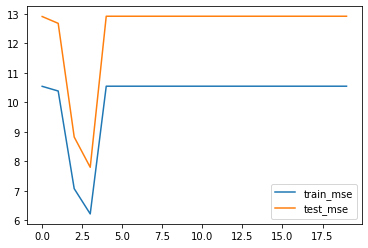

In [47]:
# 创建随机数种子
torch.manual_seed(420)  

# 实例化模型
relu_model3 = ReLU_class3(bias=False)              

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 4)

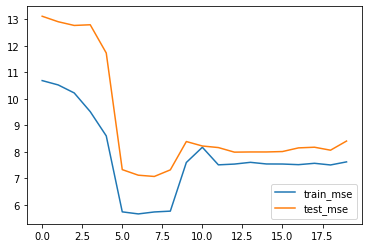

In [94]:
# 创建随机数种子
torch.manual_seed(29)  

# 实例化模型
relu_model3 = ReLU_class3(bias=False)              

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 4)

我们发现，初始参数值的选取不仅会影响模型收敛速度，甚至在某些情况下还会影响模型的最终表现。造成此现象的根本原因还是在于神经网络模型在进行训练时，不确定性过多，而在一个拥有诸多不确定性的系统中再加上不确定的初始参数，初始参数的不确定性会被这个系统放大。并且，值得一提的是，每一个epoch中的每一次迭代并不是在一个损失函数上一步步下降的，当我们使用小批量梯度下降算法时，带入不同批的数据，实际创建的损失函数也会不同。